# Day 8 and 9 - perfecting cropping of raster imagery

Following on from Day 7 when I downloaded imagery, I am going to now smooth and try image segmentation.

Rasterio works better with imagery with geospatial referencing for writing in and out so decided to move away from skimage and use rasterio. 

New packages required. 
- Shapely: `conda install -c conda-forge shapely`
- Geopandas: `conda install -c conda-forge geopandas `

Tutorials used: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

https://automating-gis-processes.github.io/CSC18/lessons/L6/plotting-raster.html

https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-in-python/export-numpy-array-to-geotiff-in-python/7

Geoprocessing with Python by Chris Garrard Chapter 9

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import show_hist
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import json

Read in the data and set the cropped file output location

In [2]:
datapath = Path('../data/amazon')
datapath18 = datapath.joinpath('20180929T140051').joinpath('amapa20180929T140051.tif')
datapath16 = datapath.joinpath('20160909T140052').joinpath('amapa20160909T140052.tif')
out_tif18 = datapath18.parent.joinpath(str(datapath18).split('/')[3] + '_crop')
out_tif16 = datapath16.parent.joinpath(str(datapath16).split('/')[3] + '_crop')

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_dict(init='epsg:32622'), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 200040.0)}


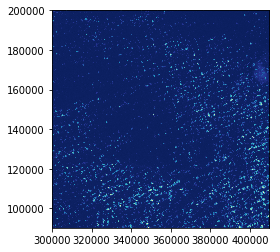

In [3]:
im18 = rasterio.open(datapath18)
im16 = rasterio.open(datapath16)
print(im18.meta)
show((im18, 1), cmap='YlGnBu_r');

This is a huge image and I want to crop it. I will create a bounding box with Shapely box and input into a geodataframe to save as a json. Rasterio mask method will crop the image with the geospatial info and it requires a GeoJson, Shapely like polygon dict: https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html

In [4]:
def crop_image(image, out_tif, minx, miny, maxx, maxy, image_crs):
    # create bounding box
    bbox = box(minx, miny, maxx, maxy)
    geo = gpd.GeoDataFrame({'geometry':bbox},
                       index=[0], crs=from_epsg(image_crs))
    geo = geo.to_crs(crs=image.crs.data)
    
    # helper function to transform gdf shapely geometry to json dict
    def getFeatures(gdf):
        return [json.loads(gdf.to_json())['features'][0]['geometry']]
    
    coords = getFeatures(geo)
    out_meta = image.meta.copy()
    
    # crop and write out new tif with the correct metadata
    out_im, out_transform = mask(dataset=image, shapes=coords, crop=True)
    out_meta.update({'driver': 'GTiff',
                'height': out_im.shape[1],
                'width': out_im.shape[2],
                'transform': out_transform})
    with rasterio.open(out_tif, 'w', **out_meta) as dst:
        dst.write(out_im)

In [6]:
crop_image(im18, out_tif18, minx=340000, miny=140000, maxx=350000, maxy=150000, image_crs=32622)
crop_image(im16, out_tif16, minx=340000, miny=140000, maxx=350000, maxy=150000, image_crs=32622)

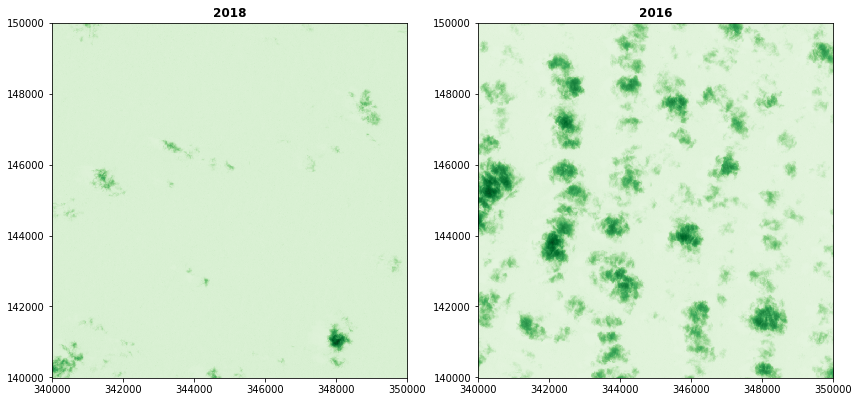

In [19]:
im18 = rasterio.open(out_tif18)
im16 = rasterio.open(out_tif16)
fig, (ax18, ax16) = plt.subplots(1,2, figsize=(14,7))
show((im18, 1), ax=ax18, cmap='Greens', title='2018')
show((im16, 1), ax=ax16, cmap='Greens', title='2016');

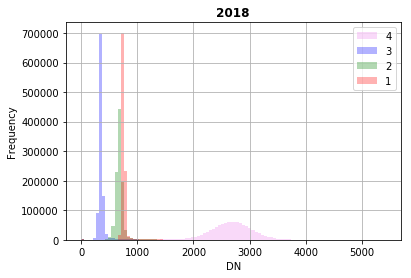

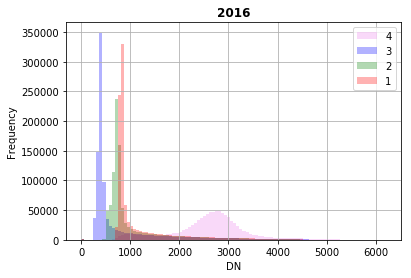

In [15]:
show_hist(im18, bins=100, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title=2018)
show_hist(im16, bins=100, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title=2016)

### Calculate NDVI
NDVI = (NIR - Red) / (NIR + Red)

In [ ]:
# image_ndvi = (image_crop[:,:,3] - image_crop[:,:,2]) / (image_crop[:,:,3] + image_crop[:,:,2])

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
# ax.imshow(image_ndvi, cmap='PiYG')
# fig.colorbar(ndvi)
# ax.axis('off');